# Assignment 3 by: Ridge Tagala (s3934367)


In [2]:
# Replace "YourFullName" with your full name; replace "YourStudentID" with your student ID (e.g. s1234567)

# Task 1: kNN-based Collaborative Filtering


In [4]:
# Start from here to write your code for Task 1. Please feel free to add more cells in this ipynb file. 
# Don't forget about comments.

## prepare data

In [6]:
# add imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the file to examine its structure
ratings_filename = 'ratings.dat'
names = ['user_id', 'movie_id', 'rating', 'timestamp']
data = pd.read_csv(ratings_filename, delimiter='::', names=names, header=None, engine='python')

# Display the first few rows to understand its structure
data.head()


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
# show all rows
pd.set_option('display.max_rows', None)

# select columns to extract 
data.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

# select a user id randomly 
random_user = np.random.choice(data['user_id'].unique())

# keep only chosen user 
filtered_data = data[data['user_id'] == random_user]

# display filtered dataframe 
print(filtered_data.head())

        user_id  movie_id  rating  timestamp
755398     4502       571       4  965095496
755399     4502      3791       3  965093553
755400     4502      2054       3  965096389
755401     4502         1       4  965097256
755402     4502         2       3  965096353


In [8]:
# (confirm data has been extracted)
# filtered_data.to_csv('filtered_data.csv', index=False)

In [9]:
# Assuming 'filtered_data' is already defined and contains the relevant DataFrame

# Count unique users and items in the filtered DataFrame
n_users = filtered_data.user_id.unique().shape[0]
n_items = filtered_data.movie_id.unique().shape[0]

# Print the number of users and items
print(str(n_users) + ' users')
print(str(n_items) + ' items')


1 users
324 items


In [10]:
# Split filtered_data into training and testing datasets
train_data, test_data = train_test_split(filtered_data, test_size=0.2)

# Display the training and testing data
train_data, test_data

(        user_id  movie_id  rating  timestamp
 755712     4502      2026       3  964989902
 755688     4502      3706       3  964987817
 755500     4502      2174       4  964988274
 755604     4502      3271       4  965095132
 755479     4502      2100       4  965096353
 755618     4502      3654       3  965094384
 755613     4502       416       3  965096867
 755614     4502      2699       3  964987897
 755547     4502      1201       4  965096719
 755462     4502      3494       4  965096794
 755573     4502      1256       4  964990037
 755594     4502      3201       4  965094147
 755599     4502      2291       4  965095695
 755586     4502      1287       4  965095046
 755420     4502       919       4  965094121
 755701     4502      3741       4  965093830
 755485     4502      1186       4  965095106
 755602     4502      1645       4  964989803
 755427     4502      3071       4  965095282
 755446     4502      2474       4  964989339
 755451     4502      3426       3

In [11]:
# Split filtered_data into training and testing datasets
train_df, test_df = train_test_split(filtered_data, test_size=0.2)

# Create mappings for user and movie IDs to zero-based indices
user_id_map = {user_id: idx for idx, user_id in enumerate(filtered_data.user_id.unique())}
movie_id_map = {movie_id: idx for idx, movie_id in enumerate(filtered_data.movie_id.unique())}

# Number of unique users and items
n_users = len(user_id_map)
n_items = len(movie_id_map)

# Initialize the training dataset matrix
train_ds = np.zeros((n_users, n_items))
for row in train_df.itertuples():
    user_idx = user_id_map[row.user_id]
    movie_idx = movie_id_map[row.movie_id]
    train_ds[user_idx, movie_idx] = row.rating
train_ds = pd.DataFrame(train_ds)

# Initialize the testing dataset matrix
test_ds = np.zeros((n_users, n_items))
for row in test_df.itertuples():
    user_idx = user_id_map[row.user_id]
    movie_idx = movie_id_map[row.movie_id]
    test_ds[user_idx, movie_idx] = row.rating
test_ds = pd.DataFrame(test_ds)

# Display the training and testing datasets
train_ds, test_ds

(   0    1    2    3    4    5    6    7    8    9    ...  314  315  316  317  \
 0  4.0  3.0  0.0  4.0  3.0  4.0  5.0  4.0  5.0  3.0  ...  3.0  4.0  0.0  3.0   
 
    318  319  320  321  322  323  
 0  3.0  4.0  4.0  0.0  3.0  4.0  
 
 [1 rows x 324 columns],
    0    1    2    3    4    5    6    7    8    9    ...  314  315  316  317  \
 0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  3.0  0.0   
 
    318  319  320  321  322  323  
 0  0.0  0.0  0.0  4.0  0.0  0.0  
 
 [1 rows x 324 columns])

## User based Collaborative fitting

## compute pearson correlation coefficient for each pair of users in training dataset

In [14]:
GAMMA = 30
EPSILON = 1e-9

np_user_pearson_corr = np.zeros((n_users, n_users))

for i, user_i_vec in enumerate(train_ds.values):
    for j, user_j_vec in enumerate(train_ds.values):

        # ratings corated by the current pair od users
        mask_i = user_i_vec > 0
        mask_j = user_j_vec > 0

        # corrated item index, skip if there are no corrated ratings
        corrated_index = np.intersect1d(np.where(mask_i), np.where(mask_j))
        if len(corrated_index) == 0:
            continue

        # average value of user_i_vec and user_j_vec
        mean_user_i = np.sum(user_i_vec) / (np.sum(np.clip(user_i_vec, 0, 1)) + EPSILON)
        mean_user_j = np.sum(user_j_vec) / (np.sum(np.clip(user_j_vec, 0, 1)) + EPSILON)

        # compute pearson corr
        user_i_sub_mean = user_i_vec[corrated_index] - mean_user_i
        user_j_sub_mean = user_j_vec[corrated_index] - mean_user_j

        r_ui_sub_r_i_sq = np.square(user_i_sub_mean)
        r_uj_sub_r_j_sq = np.square(user_j_sub_mean)

        r_ui_sum_sqrt = np.sqrt(np.sum(r_ui_sub_r_i_sq))
        r_uj_sum_sqrt = np.sqrt(np.sum(r_uj_sub_r_j_sq))

        sim = np.sum(user_i_sub_mean * user_j_sub_mean) / (r_ui_sum_sqrt * r_uj_sum_sqrt + EPSILON)

        # significance weighting
        weighted_sim = (min(len(corrated_index), GAMMA) / GAMMA) * sim

        np_user_pearson_corr[i][j] = weighted_sim

       # Print the result for each user pair
        print(f"Weighted Pearson correlation between user {i} and user {j}: {weighted_sim:.4f}")

np_user_pearson_corr

Weighted Pearson correlation between user 0 and user 0: 1.0000


array([[1.]])

## Cosign coefficient

In [16]:
# This is just here for comparison. i have chosen the pearson correlation coefficient for this task, and comparison.

In [17]:
import numpy as np

GAMMA = 30
EPSILON = 1e-9

np_user_cosine_sim = np.zeros((n_users, n_users))

for i, user_i_vec in enumerate(train_ds.values):
    for j, user_j_vec in enumerate(train_ds.values):

        # Ratings co-rated by the current pair of users
        mask_i = user_i_vec > 0
        mask_j = user_j_vec > 0

        # Co-rated item index, skip if there are no co-rated ratings
        corrated_index = np.intersect1d(np.where(mask_i), np.where(mask_j))
        if len(corrated_index) == 0:
            continue

        # Extract the ratings for the co-rated items
        user_i_ratings = user_i_vec[corrated_index]
        user_j_ratings = user_j_vec[corrated_index]

        # Compute cosine similarity
        dot_product = np.dot(user_i_ratings, user_j_ratings)
        norm_user_i = np.sqrt(np.sum(np.square(user_i_ratings)))
        norm_user_j = np.sqrt(np.sum(np.square(user_j_ratings)))
        sim = dot_product / (norm_user_i * norm_user_j + EPSILON)

        # Significance weighting
        weighted_sim = (min(len(corrated_index), GAMMA) / GAMMA) * sim

        np_user_cosine_sim[i][j] = weighted_sim

        # Print the result for each user pair
        print(f"Weighted Cosine similarity between user {i} and user {j}: {weighted_sim:.4f}")

np_user_cosine_sim


Weighted Cosine similarity between user 0 and user 0: 1.0000


array([[1.]])

In [18]:
## predict ratings

In [19]:
# predict
np_predictions = np.zeros((n_users, n_items))

# choose k and EPISOLON values
K = 100
EPSILON = 1e-9

for (i, j), rating in np.ndenumerate(test_ds.values):
    if rating > 0:
        # find top-k most similar users as the current user, remove itself
        sim_user_ids = np.argsort(np_user_pearson_corr[i])[-(K + 1):-1]

        # the coefficient values of similar users
        sim_val = np_user_pearson_corr[i][sim_user_ids]

        # the average value of the current user's ratings
        sim_users = train_ds.values[sim_user_ids]
        user_mean = np.sum(train_ds.values[i]) / (np.sum(np.clip(train_ds.values[i], 0, 1)) + EPSILON)
        sim_user_mean = np.sum(sim_users, axis=1) / (np.sum(np.clip(sim_users, 0, 1), axis=1) + EPSILON)

        # select the users who rated item j
        mask_rated_j = sim_users[:, j] > 0
        
        # sim(u, v) * (r_vj - mean_v)
        sim_r_sum_mean = sim_val[mask_rated_j] * (sim_users[mask_rated_j, j] - sim_user_mean[mask_rated_j])

        # filter unrated items
        #w = np.clip(sim_users[mask_rated_j, j], 0, 1)
        #sim_r_sum_mean *= w
        #print(sim_users[:, j])
        
        np_predictions[i][j] = user_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val[mask_rated_j]) + EPSILON)
        np_predictions[i][j] = np.clip(np_predictions[i][j], 0, 5)
    

In [20]:
#==================MAE on Testing set===================#
labels = test_ds.values

# absolute error on all ratings
absolute_error = np.abs(np_predictions - labels)

# weight
weight = np.clip(labels, 0, 1)

# absoulte error on rated ratings
abs_error = absolute_error * weight

# MAE
MAE = np.sum(abs_error) / np.sum(weight)

print("MAE on Tesing set (User-based): " + str(MAE));

MAE on Tesing set (User-based): 0.5340065340136791


In [21]:
#==================RMSE on Testing set===================
labels = test_ds.values

# squared error on all ratings
squared_error = np.square(np_predictions - labels)
weight = np.clip(labels, 0, 1)

# squared error on rated ratings
squared_error = squared_error * weight

# RMSE
RMSE = np.sqrt(np.sum(squared_error) / np.sum(weight))

print("RMSE on Tesing set (User-based): " + str(RMSE));

RMSE on Tesing set (User-based): 0.6929651001383715


## RMSE vs MAE vs K-value

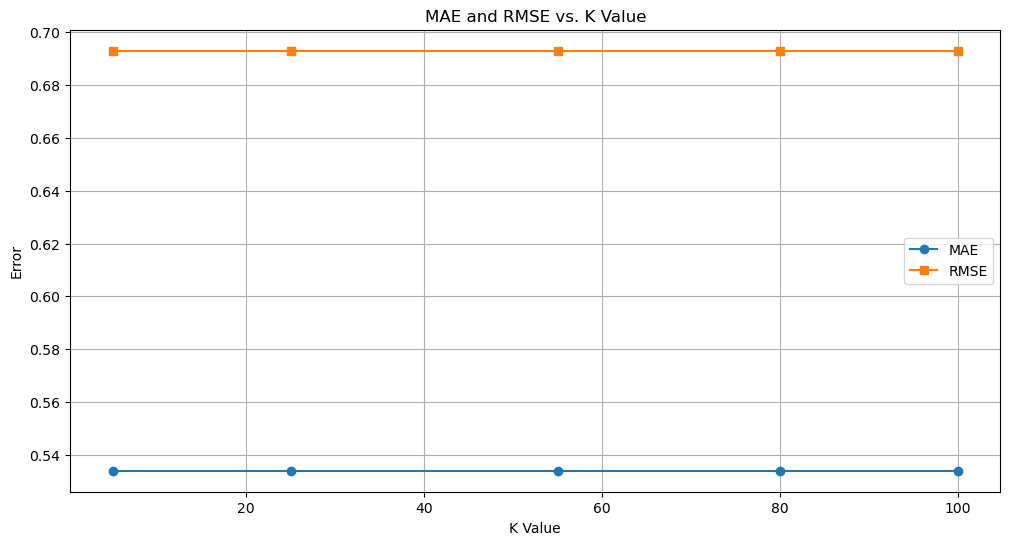

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Arrays to store MAE and RMSE for different K values
k_values = [5, 25, 55, 80, 100]
mae_list = []
rmse_list = []

# Loop through different K values
for K in k_values:
    np_predictions = np.zeros((n_users, n_items))
    
    # Perform prediction using the current K value
    for (i, j), rating in np.ndenumerate(test_ds.values):
        if rating > 0:
            # find top-k most similar users as the current user, remove itself
            sim_user_ids = np.argsort(np_user_pearson_corr[i])[-(K + 1):-1]

            # the coefficient values of similar users
            sim_val = np_user_pearson_corr[i][sim_user_ids]

            # the average value of the current user's ratings
            sim_users = train_ds.values[sim_user_ids]
            user_mean = np.sum(train_ds.values[i]) / (np.sum(np.clip(train_ds.values[i], 0, 1)) + EPSILON)
            sim_user_mean = np.sum(sim_users, axis=1) / (np.sum(np.clip(sim_users, 0, 1), axis=1) + EPSILON)

            # select the users who rated item j
            mask_rated_j = sim_users[:, j] > 0
            
            # sim(u, v) * (r_vj - mean_v)
            sim_r_sum_mean = sim_val[mask_rated_j] * (sim_users[mask_rated_j, j] - sim_user_mean[mask_rated_j])

            # predict rating for user i on item j
            np_predictions[i][j] = user_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val[mask_rated_j]) + EPSILON)
            np_predictions[i][j] = np.clip(np_predictions[i][j], 0, 5)
    
    # Calculate MAE and RMSE for the current predictions
    labels = test_ds.values
    weight = np.clip(labels, 0, 1)
    mae = np.sum(np.abs(np_predictions - labels) * weight) / np.sum(weight)
    rmse = np.sqrt(np.sum(np.square(np_predictions - labels) * weight) / np.sum(weight))
    
    # Store the results
    mae_list.append(mae)
    rmse_list.append(rmse)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(k_values, mae_list, label='MAE', marker='o')
plt.plot(k_values, rmse_list, label='RMSE', marker='s')
plt.xlabel('K Value')
plt.ylabel('Error')
plt.title('MAE and RMSE vs. K Value')
plt.legend()
plt.grid()
plt.show()


## RMSE vs K-value

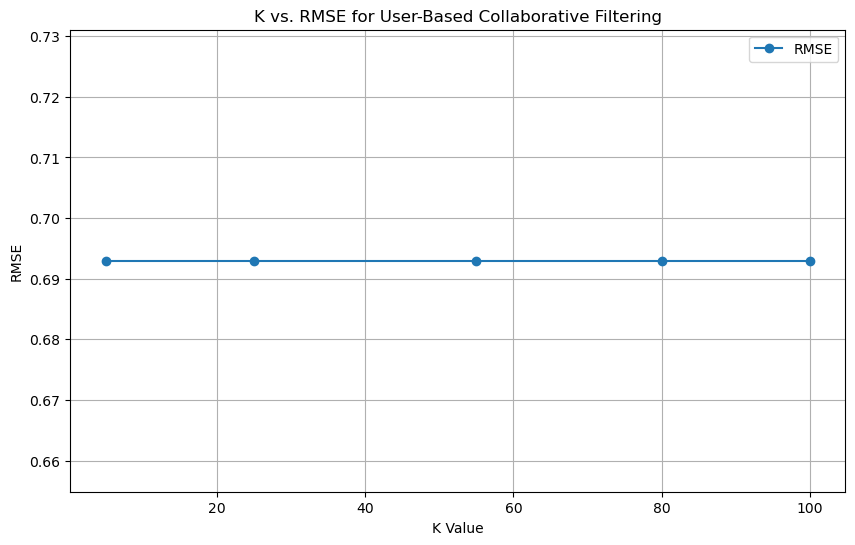

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Arrays to store RMSE values for different K values
# Example K values: 5, 25, 45, 65, 85
k_values = [5, 25, 55, 80, 100]
rmse_list = []

# Loop through different K values to compute RMSE
for K in k_values:
    np_predictions = np.zeros((n_users, n_items))
    
    # Perform prediction using the current K value
    for (i, j), rating in np.ndenumerate(test_ds.values):
        if rating > 0:
            # find top-k most similar users as the current user, remove itself
            sim_user_ids = np.argsort(np_user_pearson_corr[i])[-(K + 1):-1]

            # the coefficient values of similar users
            sim_val = np_user_pearson_corr[i][sim_user_ids]

            # the average value of the current user's ratings
            sim_users = train_ds.values[sim_user_ids]
            user_mean = np.sum(train_ds.values[i]) / (np.sum(np.clip(train_ds.values[i], 0, 1)) + EPSILON)
            sim_user_mean = np.sum(sim_users, axis=1) / (np.sum(np.clip(sim_users, 0, 1), axis=1) + EPSILON)

            # select the users who rated item j
            mask_rated_j = sim_users[:, j] > 0
            
            # sim(u, v) * (r_vj - mean_v)
            sim_r_sum_mean = sim_val[mask_rated_j] * (sim_users[mask_rated_j, j] - sim_user_mean[mask_rated_j])

            # predict rating for user i on item j
            np_predictions[i][j] = user_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val[mask_rated_j]) + EPSILON)
            np_predictions[i][j] = np.clip(np_predictions[i][j], 0, 5)
    
    # Calculate RMSE for the current predictions
    labels = test_ds.values
    weight = np.clip(labels, 0, 1)
    rmse = np.sqrt(np.sum(np.square(np_predictions - labels) * weight) / np.sum(weight))
    
    # Store the RMSE value
    rmse_list.append(rmse)

# Plotting K vs RMSE
plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_list, label='RMSE', marker='o')
plt.xlabel('K Value')
plt.ylabel('RMSE')
plt.title('K vs. RMSE for User-Based Collaborative Filtering')
plt.legend()
plt.grid()
plt.show()


# Task 2: Matrix Factorization-based Recommendation

## preparing data 

In [28]:
# add imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the file to examine its structure
ratings_filename = 'ratings.dat'
names = ['user_id', 'movie_id', 'rating', 'timestamp']
data = pd.read_csv(ratings_filename, delimiter='::', names=names, header=None, engine='python')

# Display the first few rows to understand its structure
data.head()


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [29]:
# Show all rows
pd.set_option('display.max_rows', None)

# Select columns to extract
data.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

# Select 5 random user IDs
random_users = np.random.choice(data['user_id'].unique(), size=5, replace=False)

# Keep only the data for the chosen users
filtered_data = data[data['user_id'].isin(random_users)]

# Display the filtered DataFrame
print(filtered_data.head())


       user_id  movie_id  rating  timestamp
35489      240      1320       4  976755798
35490      240      1250       4  976757218
35491      240      2054       2  976755798
35492      240       589       3  976756562
35493      240      1333       4  976756022


In [30]:
# (confirm data has been extracted)
# filtered_data.to_csv('filtered_data_5_users.csv', index=False)

## Factorisation Technique Chosen: ALS (Alternating Least Square)

In [32]:
# n_factors = 15
import pandas as pd
import numpy as np

# Assuming 'filtered_data' contains the user-item ratings data
# Ensure 'filtered_data' is in the format: user_id, movie_id, rating

# Prepare the user-item matrix
n_users = filtered_data.user_id.nunique()
n_items = filtered_data.movie_id.nunique()

# Create mappings from user/movie IDs to indices
user_id_map = {user_id: idx for idx, user_id in enumerate(filtered_data.user_id.unique())}
movie_id_map = {movie_id: idx for idx, movie_id in enumerate(filtered_data.movie_id.unique())}

# Initialize user-item matrix with zeros
user_item_matrix = np.zeros((n_users, n_items))

# Fill the matrix with the ratings
for row in filtered_data.itertuples():
    user_idx = user_id_map[row.user_id]
    movie_idx = movie_id_map[row.movie_id]
    user_item_matrix[user_idx, movie_idx] = row.rating

# ALS Parameters
n_factors = 15  # Number of latent factors
n_iterations = 20  # Number of ALS iterations
regularization = 0.1  # Regularization parameter

# Initialize user and item factors randomly
user_factors = np.random.rand(n_users, n_factors)
item_factors = np.random.rand(n_items, n_factors)

# ALS Function to solve for user or item factors
def als_step(X, Y, lambda_reg):
    """ Solve for the factors in ALS. """
    YTY = Y.T @ Y
    lambda_eye = lambda_reg * np.eye(YTY.shape[0])
    return np.linalg.solve(YTY + lambda_eye, X @ Y)

# Perform ALS iterations
for iteration in range(n_iterations):
    # Update user factors
    user_factors = np.array([als_step(user_item_matrix[u, :], item_factors, regularization) for u in range(n_users)])
    # Update item factors
    item_factors = np.array([als_step(user_item_matrix[:, i].T, user_factors, regularization) for i in range(n_items)])

    # Optionally, print the iteration number
    # print(f"Iteration {iteration + 1}/{n_iterations} completed.")
print(f"all {n_iterations} Iterations complete.\n")

# Reconstruct the user-item matrix using the learned factors
predicted_ratings = user_factors @ item_factors.T

# Evaluate the model (optional)
# Get the non-zero indices in the original matrix
non_zero_indices = np.where(user_item_matrix > 0)
actual_ratings = user_item_matrix[non_zero_indices]
predicted_ratings_filtered = predicted_ratings[non_zero_indices]

# Calculate RMSE
rmse = np.sqrt(np.mean((actual_ratings - predicted_ratings_filtered) ** 2))
print(f'RMSE for ALS: {rmse:.4f}')

# Convert the predicted matrix back to a DataFrame for easy viewing
predicted_df = pd.DataFrame(predicted_ratings, index=user_id_map.keys(), columns=movie_id_map.keys())
print(predicted_df.head())


all 20 Iterations complete.

RMSE for ALS: 0.0672
          1320      1250      2054      589       1333      1334      1262  \
240   3.913470  3.909947  1.959498  2.945412  3.909947  2.932460  3.909947   
506  -0.005755 -0.001836  0.000249 -0.003102 -0.001836 -0.001377 -0.001836   
757   0.009075  0.006032  2.951394  4.920411  0.006032  0.004524  0.006032   
890   4.910183  0.002819  0.003235  4.915317  0.002819  0.002114  0.002819   
5474  0.007176  0.002518  0.000140  2.935541  0.002518  0.001888  0.002518   

          1265      733       1196  ...      2968      1253      1653  \
240   2.941010  1.961006  3.922824  ...  0.001259  0.002518  0.002518   
506   0.000512  0.000638 -0.002694  ...  0.000166  0.000332  0.000332   
757   3.934203  3.934186  4.920937  ... -0.000746 -0.001492 -0.001492   
890   0.008275  0.003844  3.935480  ...  0.001863  0.003727  0.003727   
5474  3.908208 -0.000233  3.912191  ...  1.953906  3.907811  3.907811   

          2662      2664      2324      10

## AP and NDCG and n-factors with ALS 

In [34]:
import pandas as pd
import numpy as np

# Assuming 'filtered_data' contains the user-item ratings data
# Ensure 'filtered_data' is in the format: user_id, movie_id, rating

# 1: Prepare the user-item matrix
n_users = filtered_data.user_id.nunique()
n_items = filtered_data.movie_id.nunique()

# Create mappings from user/movie IDs to indices
user_id_map = {user_id: idx for idx, user_id in enumerate(filtered_data.user_id.unique())}
movie_id_map = {movie_id: idx for idx, movie_id in enumerate(filtered_data.movie_id.unique())}

# Initialize user-item matrix with zeros
user_item_matrix = np.zeros((n_users, n_items))

# Fill the matrix with the ratings
for row in filtered_data.itertuples():
    user_idx = user_id_map[row.user_id]
    movie_idx = movie_id_map[row.movie_id]
    user_item_matrix[user_idx, movie_idx] = row.rating

# 2: ALS Parameters
n_factors = 15  # Number of latent factors
n_iterations = 20  # Number of ALS iterations
regularization = 0.1  # Regularization parameter

# Initialize user and item factors randomly
user_factors = np.random.rand(n_users, n_factors)
item_factors = np.random.rand(n_items, n_factors)

# ALS Function to solve for user or item factors
def als_step(X, Y, lambda_reg):
    """ Solve for the factors in ALS. """
    YTY = Y.T @ Y
    lambda_eye = lambda_reg * np.eye(YTY.shape[0])
    return np.linalg.solve(YTY + lambda_eye, X @ Y)

#   3: Perform ALS iterations
for iteration in range(n_iterations):
    # Update user factors
    user_factors = np.array([als_step(user_item_matrix[u, :], item_factors, regularization) for u in range(n_users)])
    # Update item factors
    item_factors = np.array([als_step(user_item_matrix[:, i].T, user_factors, regularization) for i in range(n_items)])

print(f"All {n_iterations} iterations complete.\n")

# 4: Reconstruct the user-item matrix using the learned factors
predicted_ratings = user_factors @ item_factors.T

# 5: Evaluate the model with RMSE
# Get the non-zero indices in the original matrix
non_zero_indices = np.where(user_item_matrix > 0)
actual_ratings = user_item_matrix[non_zero_indices]
predicted_ratings_filtered = predicted_ratings[non_zero_indices]

# Calculate RMSE
rmse = np.sqrt(np.mean((actual_ratings - predicted_ratings_filtered) ** 2))
print(f'RMSE for ALS: {rmse:.4f}')

# 6: Convert the predicted matrix back to a DataFrame for easy viewing
predicted_df = pd.DataFrame(predicted_ratings, index=user_id_map.keys(), columns=movie_id_map.keys())
print(predicted_df.head())


All 20 iterations complete.

RMSE for ALS: 0.0671
          1320      1250      2054      589       1333      1334      1262  \
240   3.912777  3.908020  1.960053  2.946146  3.908020  2.931015  3.908020   
506  -0.001187  0.000502  0.002761  0.002422  0.000502  0.000377  0.000502   
757   0.018133  0.008058  2.949365  4.925726  0.008058  0.006043  0.008058   
890   4.912524  0.003806  0.007948  4.923934  0.003806  0.002854  0.003806   
5474  0.004212  0.000403  0.000914  2.935262  0.000403  0.000302  0.000403   

          1265      733       1196  ...      2968      1253      1653  \
240   2.939475  1.962068  3.922300  ...  0.000201  0.000403  0.000403   
506   0.003125  0.003598  0.002736  ... -0.000299 -0.000598 -0.000598   
757   3.934110  3.931144  4.925963  ...  0.000475  0.000951  0.000951   
890   0.013962  0.009963  3.943904  ...  0.001524  0.003048  0.003048   
5474  3.907869  0.001152  3.911255  ...  1.953308  3.906616  3.906616   

          2662      2664      2324      10

In [35]:
# Create reverse mappings from the index to original user and movie labels
user_id_map_reverse = {idx: user_id for user_id, idx in user_id_map.items()}
movie_id_map_reverse = {idx: movie_id for movie_id, idx in movie_id_map.items()}

# Update the DataFrame index and columns to use the original user and movie labels
# Use a fallback for any unmapped indices
predicted_df.index = [user_id_map_reverse.get(idx, f"Unknown User {idx}") for idx in predicted_df.index]
predicted_df.columns = [movie_id_map_reverse.get(idx, f"Unknown Movie {idx}") for idx in predicted_df.columns]

# Optionally, if 'filtered_data' contains movie titles, you can use those for the columns
if 'movie_title' in filtered_data.columns:
    # Create a mapping from movie_id to movie_title
    movie_title_map = filtered_data.set_index('movie_id')['movie_title'].to_dict()
    # Update columns with movie titles, using the movie ID as a fallback
    predicted_df.columns = [movie_title_map.get(movie_id, f"Movie {movie_id}") for movie_id in predicted_df.columns]

# Display the updated DataFrame with labels
print(predicted_df.head())


                   Unknown Movie 1320  Unknown Movie 1250  Unknown Movie 2054  \
Unknown User 240             3.912777            3.908020            1.960053   
Unknown User 506            -0.001187            0.000502            0.002761   
Unknown User 757             0.018133            0.008058            2.949365   
Unknown User 890             4.912524            0.003806            0.007948   
Unknown User 5474            0.004212            0.000403            0.000914   

                        586  Unknown Movie 1333  Unknown Movie 1334  \
Unknown User 240   2.946146            3.908020            2.931015   
Unknown User 506   0.002422            0.000502            0.000377   
Unknown User 757   4.925726            0.008058            0.006043   
Unknown User 890   4.923934            0.003806            0.002854   
Unknown User 5474  2.935262            0.000403            0.000302   

                   Unknown Movie 1262  Unknown Movie 1265  Unknown Movie 733  \
Unknow

In [36]:
import pandas as pd

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Display the entire DataFrame
print(predicted_df)

# Optional: To revert back to the default settings afterwards
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

                   Unknown Movie 1320  Unknown Movie 1250  Unknown Movie 2054  \
Unknown User 240             3.912777            3.908020            1.960053   
Unknown User 506            -0.001187            0.000502            0.002761   
Unknown User 757             0.018133            0.008058            2.949365   
Unknown User 890             4.912524            0.003806            0.007948   
Unknown User 5474            0.004212            0.000403            0.000914   

                        586  Unknown Movie 1333  Unknown Movie 1334  \
Unknown User 240   2.946146            3.908020            2.931015   
Unknown User 506   0.002422            0.000502            0.000377   
Unknown User 757   4.925726            0.008058            0.006043   
Unknown User 890   4.923934            0.003806            0.002854   
Unknown User 5474  2.935262            0.000403            0.000302   

                   Unknown Movie 1262  Unknown Movie 1265  Unknown Movie 733  \
Unknow

## n_factors vs RMSE on ALS graph

n_factors: 5, RMSE: 0.0575
n_factors: 10, RMSE: 0.0666
n_factors: 15, RMSE: 0.0674
n_factors: 20, RMSE: 0.0663
n_factors: 25, RMSE: 0.0666
n_factors: 30, RMSE: 0.0616


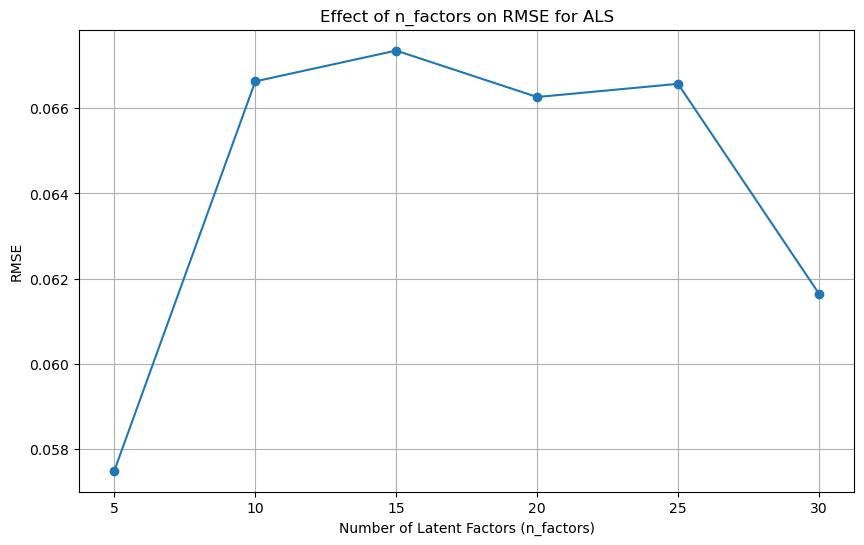

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# List of different numbers of latent factors to test
n_factors_list = [5, 10, 15, 20, 25, 30]
rmse_values = []

# Function to perform ALS and calculate RMSE for different n_factors
def run_als_with_different_factors(n_factors, user_item_matrix, regularization, n_iterations):
    # Initialize user and item factors randomly
    n_users, n_items = user_item_matrix.shape
    user_factors = np.random.rand(n_users, n_factors)
    item_factors = np.random.rand(n_items, n_factors)
    
    # Perform ALS iterations
    for iteration in range(n_iterations):
        # Update user factors
        user_factors = np.array([als_step(user_item_matrix[u, :], item_factors, regularization) for u in range(n_users)])
        # Update item factors
        item_factors = np.array([als_step(user_item_matrix[:, i].T, user_factors, regularization) for i in range(n_items)])
    
    # Reconstruct the predicted ratings
    predicted_ratings = user_factors @ item_factors.T
    # Calculate and return RMSE
    non_zero_indices = np.where(user_item_matrix > 0)
    actual_ratings = user_item_matrix[non_zero_indices]
    predicted_ratings_filtered = predicted_ratings[non_zero_indices]
    rmse = np.sqrt(np.mean((actual_ratings - predicted_ratings_filtered) ** 2))
    return rmse

# Loop over each n_factors and calculate the corresponding RMSE
for n_factors in n_factors_list:
    rmse = run_als_with_different_factors(n_factors, user_item_matrix, regularization=0.1, n_iterations=20)
    rmse_values.append(rmse)
    print(f'n_factors: {n_factors}, RMSE: {rmse:.4f}')

# Plotting n_factors vs RMSE
plt.figure(figsize=(10, 6))
plt.plot(n_factors_list, rmse_values, marker='o', linestyle='-')
plt.xlabel('Number of Latent Factors (n_factors)')
plt.ylabel('RMSE')
plt.title('Effect of n_factors on RMSE for ALS')
plt.grid()
plt.show()


In [39]:
# n_factors = 5
import pandas as pd
import numpy as np

# Assuming 'filtered_data' contains the user-item ratings data
# Ensure 'filtered_data' is in the format: user_id, movie_id, rating

# 1: Prepare the user-item matrix
n_users = filtered_data.user_id.nunique()
n_items = filtered_data.movie_id.nunique()

# Create mappings from user/movie IDs to indices
user_id_map = {user_id: idx for idx, user_id in enumerate(filtered_data.user_id.unique())}
movie_id_map = {movie_id: idx for idx, movie_id in enumerate(filtered_data.movie_id.unique())}

# Initialize user-item matrix with zeros
user_item_matrix = np.zeros((n_users, n_items))

# Fill the matrix with the ratings
for row in filtered_data.itertuples():
    user_idx = user_id_map[row.user_id]
    movie_idx = movie_id_map[row.movie_id]
    user_item_matrix[user_idx, movie_idx] = row.rating

# 2: ALS Parameters
n_factors = 5  # Number of latent factors
n_iterations = 20  # Number of ALS iterations
regularization = 0.1  # Regularization parameter

# Initialize user and item factors randomly
user_factors = np.random.rand(n_users, n_factors)
item_factors = np.random.rand(n_items, n_factors)

# ALS Function to solve for user or item factors
def als_step(X, Y, lambda_reg):
    """ Solve for the factors in ALS. """
    YTY = Y.T @ Y
    lambda_eye = lambda_reg * np.eye(YTY.shape[0])
    return np.linalg.solve(YTY + lambda_eye, X @ Y)

# 3: Perform ALS iterations
for iteration in range(n_iterations):
    # Update user factors
    user_factors = np.array([als_step(user_item_matrix[u, :], item_factors, regularization) for u in range(n_users)])
    # Update item factors
    item_factors = np.array([als_step(user_item_matrix[:, i].T, user_factors, regularization) for i in range(n_items)])

    # Optionally, print the iteration number
    # print(f"Iteration {iteration + 1}/{n_iterations} completed.")
print(f"all {n_iterations} Iterations complete.\n")

#   4: Reconstruct the user-item matrix using the learned factors
predicted_ratings = user_factors @ item_factors.T

# 5: Evaluate the model (optional)
# Get the non-zero indices in the original matrix
non_zero_indices = np.where(user_item_matrix > 0)
actual_ratings = user_item_matrix[non_zero_indices]
predicted_ratings_filtered = predicted_ratings[non_zero_indices]

# Calculate RMSE
rmse = np.sqrt(np.mean((actual_ratings - predicted_ratings_filtered) ** 2))
print(f'RMSE for ALS: {rmse:.4f}')

# 6: Convert the predicted matrix back to a DataFrame for easy viewing
predicted_df = pd.DataFrame(predicted_ratings, index=user_id_map.keys(), columns=movie_id_map.keys())
print(predicted_df.head())


all 20 Iterations complete.

RMSE for ALS: 0.0615
          1320      1250      2054      589       1333      1334      1262  \
240   3.919811  3.911847  1.963448  2.953248  3.911847  2.933885  3.911847   
506   0.003559  0.000978  0.005608  0.014889  0.000978  0.000733  0.000978   
757   0.032212  0.010033  2.958101  4.957177  0.010033  0.007524  0.010033   
890   4.910461  0.006371  0.016494  4.927185  0.006371  0.004778  0.006371   
5474 -0.007963 -0.001523  0.004904  2.941057 -0.001523 -0.001142 -0.001523   

          1265      733       1196  ...      2968      1253      1653  \
240   2.942395  1.965956  3.929236  ... -0.000761 -0.001523 -0.001523   
506   0.011615  0.007314  0.015632  ...  0.002028  0.004057  0.004057   
757   3.952524  3.942462  4.957137  ...  0.003777  0.007554  0.007554   
890   0.017371  0.020929  3.946671  ... -0.002576 -0.005152 -0.005152   
5474  3.925341  0.006792  3.921697  ...  1.959465  3.918930  3.918930   

          2662      2664      2324      10

# Task 3: Ranking-based Evaluation and Comparison

In [41]:
## preparing data

In [42]:
# add imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the file to examine its structure
ratings_filename = 'ratings.dat'
names = ['user_id', 'movie_id', 'rating', 'timestamp']
data = pd.read_csv(ratings_filename, delimiter='::', names=names, header=None, engine='python')

# Display the first few rows to understand its structure
data.head()


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## Choosing 10 users with 100 or more ratings

In [44]:
# Add imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the file to examine its structure
ratings_filename = 'ratings.dat'
names = ['user_id', 'movie_id', 'rating', 'timestamp']
data = pd.read_csv(ratings_filename, delimiter='::', names=names, header=None, engine='python', low_memory=True) # for performance purposes

# 1: Count the number of ratings per user and filter for those with at least 100 ratings
user_counts = data['user_id'].value_counts()
users_with_100_ratings = user_counts[user_counts >= 100].index.values

# 2: Randomly select 10 users from this filtered list
selected_users = np.random.choice(users_with_100_ratings, size=10, replace=False)

#   3: Filter the data for the selected users
filtered_data = data[data['user_id'].isin(selected_users)]

# 4: Save the filtered data to a CSV file
filtered_data.to_csv('filtered_data_task3.csv', index=False)

# Output the selected users
print("Selected Users with at least 100 ratings:")
for user_id in selected_users:
    print(f"User ID: {user_id}")

print("\nFiltered data for the selected users has been saved to 'filtered_data_task3.csv'.")


Selected Users with at least 100 ratings:
User ID: 5367
User ID: 2649
User ID: 1687
User ID: 587
User ID: 4093
User ID: 3585
User ID: 872
User ID: 5341
User ID: 5126
User ID: 5625

Filtered data for the selected users has been saved to 'filtered_data_task3.csv'.


## Evaluation

In [46]:
import pandas as pd
import numpy as np
from sklearn.metrics import average_precision_score, ndcg_score

# 1: Load data from 'filtered_data_task3.csv'
data = pd.read_csv('filtered_data_task3.csv')

# 2: Filter users who have rated at least 100 movies
user_counts = data['user_id'].value_counts()
users_with_100_ratings = user_counts[user_counts >= 100].index.values

# 3: Randomly select 10 users from this filtered list
selected_users = np.random.choice(users_with_100_ratings, size=10, replace=False)

# 4: Identify top 20 movies by average rating (or other criterion) among the selected users
top_movies = (
    data[data['user_id'].isin(selected_users)]
    .groupby('movie_id')['rating']
    .mean()
    .sort_values(ascending=False)
    .head(20)
    .index.values
)

# 5: Recommend the top 20 movies to each selected user
recommendations = {user: top_movies for user in selected_users}

# 6: Evaluate the recommendations using AP and NDCG
ap_scores = []
ndcg_scores = []

for user in selected_users:
    # Get the user's actual ratings for the recommended movies
    user_data = data[data['user_id'] == user]
    actual_ratings = user_data[user_data['movie_id'].isin(top_movies)]
    
    # Create binary relevance for AP/NDCG (1 for relevant, 0 for non-relevant)
    relevance = np.isin(top_movies, actual_ratings['movie_id']).astype(int)
    
    # Check if there are any positive classes in relevance
    if relevance.sum() > 0:
        # Calculate Average Precision (AP)
        ap_score = average_precision_score(relevance, np.ones_like(relevance))
        ndcg = ndcg_score([relevance], [np.ones_like(relevance)])
    else:
        # If no relevant items are found, set AP and NDCG to 0
        ap_score = 0
        ndcg = 0
    
    ap_scores.append(ap_score)
    ndcg_scores.append(ndcg)

# 7: Display the results
print("Evaluation Results:")
for i, user in enumerate(selected_users):
    print(f"User ID: {user}")
    print(f"  - Average Precision (AP): {ap_scores[i]:.4f}")
    print(f"  - Normalized Discounted Cumulative Gain (NDCG): {ndcg_scores[i]:.4f}")

print("\nAverage AP:", np.mean(ap_scores))
print("Average NDCG:", np.mean(ndcg_scores))


Evaluation Results:
User ID: 5341
  - Average Precision (AP): 0.0000
  - Normalized Discounted Cumulative Gain (NDCG): 0.0000
User ID: 2649
  - Average Precision (AP): 0.0000
  - Normalized Discounted Cumulative Gain (NDCG): 0.0000
User ID: 5367
  - Average Precision (AP): 0.4500
  - Normalized Discounted Cumulative Gain (NDCG): 0.7447
User ID: 1687
  - Average Precision (AP): 0.3500
  - Normalized Discounted Cumulative Gain (NDCG): 0.6773
User ID: 4093
  - Average Precision (AP): 0.1000
  - Normalized Discounted Cumulative Gain (NDCG): 0.4317
User ID: 3585
  - Average Precision (AP): 0.1000
  - Normalized Discounted Cumulative Gain (NDCG): 0.4317
User ID: 872
  - Average Precision (AP): 0.1000
  - Normalized Discounted Cumulative Gain (NDCG): 0.4317
User ID: 5625
  - Average Precision (AP): 0.1000
  - Normalized Discounted Cumulative Gain (NDCG): 0.4317
User ID: 587
  - Average Precision (AP): 0.1000
  - Normalized Discounted Cumulative Gain (NDCG): 0.4317
User ID: 5126
  - Average Pr

## KNNCF

In [48]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score, ndcg_score
from scipy.sparse import csr_matrix

# Load data and filter users with at least 100 ratings
user_counts = data['user_id'].value_counts()
users_with_100_ratings = user_counts[user_counts >= 100].index.values
selected_users = np.random.choice(users_with_100_ratings, size=10, replace=False)

# Create user-item matrix
user_item_matrix = data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
sparse_user_item = csr_matrix(user_item_matrix)

# Fit the kNN model
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
knn_model.fit(sparse_user_item)

# Generate recommendations for each selected user
knn_recommendations = {}
for user in selected_users:
    user_index = np.where(user_item_matrix.index == user)[0][0]
    distances, indices = knn_model.kneighbors(sparse_user_item[user_index], n_neighbors=10)

    # Aggregate movies rated by similar users, then sort by average rating
    similar_users = indices.flatten()
    similar_user_ratings = user_item_matrix.iloc[similar_users].mean(axis=0).sort_values(ascending=False)
    recommended_movies = similar_user_ratings.head(20).index.values
    knn_recommendations[user] = recommended_movies

# Evaluation using AP and NDCG
knn_ap_scores = []
knn_ndcg_scores = []

for user in selected_users:
    actual_ratings = data[(data['user_id'] == user) & (data['movie_id'].isin(knn_recommendations[user]))]
    relevance = np.isin(knn_recommendations[user], actual_ratings['movie_id']).astype(int)
    if relevance.sum() > 0:
        knn_ap_scores.append(average_precision_score(relevance, np.ones_like(relevance)))
        knn_ndcg_scores.append(ndcg_score([relevance], [np.ones_like(relevance)]))
    else:
        knn_ap_scores.append(0)
        knn_ndcg_scores.append(0)

print("kNN-based Collaborative Filtering Results")
print("Average AP:", np.mean(knn_ap_scores))
print("Average NDCG:", np.mean(knn_ndcg_scores))


kNN-based Collaborative Filtering Results
Average AP: 0.67
Average NDCG: 0.847415202819833


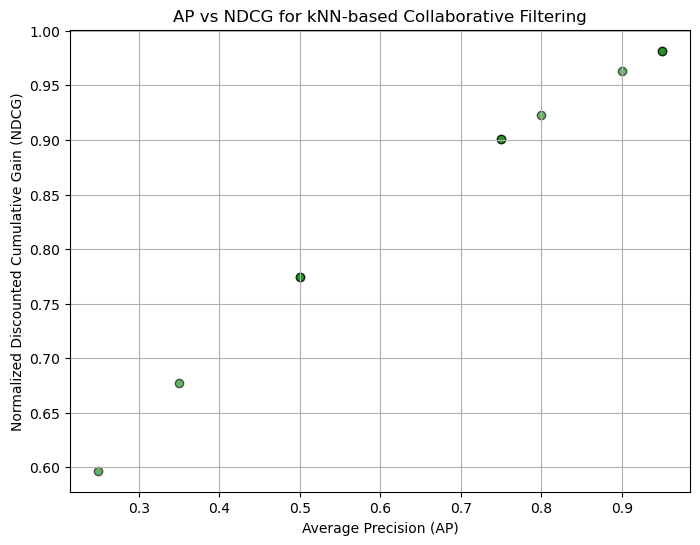

Average AP across users: 0.6700
Average NDCG across users: 0.8474


In [49]:
import matplotlib.pyplot as plt

# Generate a scatter plot of AP vs NDCG for each user in the kNN-based Collaborative Filtering results
plt.figure(figsize=(8, 6))
plt.scatter(knn_ap_scores, knn_ndcg_scores, color='green', alpha=0.6, edgecolor='k')
plt.title("AP vs NDCG for kNN-based Collaborative Filtering")
plt.xlabel("Average Precision (AP)")
plt.ylabel("Normalized Discounted Cumulative Gain (NDCG)")
plt.grid(True)
plt.show()

# Optional: Print average AP and NDCG values for reference
print(f"Average AP across users: {np.mean(knn_ap_scores):.4f}")
print(f"Average NDCG across users: {np.mean(knn_ndcg_scores):.4f}")


## IMFR

In [51]:
import pandas as pd
import numpy as np
from sklearn.metrics import average_precision_score, ndcg_score

# Assuming 'filtered_data' contains the user-item ratings data
# Ensure 'filtered_data' is in the format: user_id, movie_id, rating
# Load data from 'filtered_data_task3.csv'
data = pd.read_csv('filtered_data_task3.csv')
# Load data and filter users with at least 100 ratings
user_counts = data['user_id'].value_counts()
users_with_100_ratings = user_counts[user_counts >= 100].index.values
selected_users = np.random.choice(users_with_100_ratings, size=10, replace=False)

# 1: Prepare the user-item matrix
n_users = filtered_data.user_id.nunique()
n_items = filtered_data.movie_id.nunique()

# Create mappings from user/movie IDs to indices
user_id_map = {user_id: idx for idx, user_id in enumerate(filtered_data.user_id.unique())}
movie_id_map = {movie_id: idx for idx, movie_id in enumerate(filtered_data.movie_id.unique())}

# Initialize user-item matrix with zeros
user_item_matrix = np.zeros((n_users, n_items))

# Fill the matrix with the ratings
for row in filtered_data.itertuples():
    user_idx = user_id_map[row.user_id]
    movie_idx = movie_id_map[row.movie_id]
    user_item_matrix[user_idx, movie_idx] = row.rating

# 2: Optimized ALS Parameters
n_factors = 50  # Increased number of latent factors
n_iterations = 20  # Increased ALS iterations
regularization = 0.05  # Reduced regularization

# Initialize user and item factors randomly
user_factors = np.random.rand(n_users, n_factors)
item_factors = np.random.rand(n_items, n_factors)

# ALS Function to solve for user or item factors
def als_step(X, Y, lambda_reg):
    """ Solve for the factors in ALS. """
    YTY = Y.T @ Y
    lambda_eye = lambda_reg * np.eye(YTY.shape[0])
    return np.linalg.solve(YTY + lambda_eye, X @ Y)

# 3: Perform ALS iterations with bias
user_bias = np.zeros(n_users)
item_bias = np.zeros(n_items)
global_bias = np.mean(user_item_matrix[user_item_matrix > 0])

for iteration in range(n_iterations):
    # Update user factors with user bias
    user_factors = np.array([
        als_step(user_item_matrix[u, :] - item_bias - global_bias, item_factors, regularization)
        for u in range(n_users)
    ])
    
    # Update item factors with item bias
    item_factors = np.array([
        als_step(user_item_matrix[:, i].T - user_bias - global_bias, user_factors, regularization)
        for i in range(n_items)
    ])
    
    # Update biases
    user_bias = np.mean(user_item_matrix - global_bias - item_bias, axis=1)
    item_bias = np.mean(user_item_matrix - global_bias - user_bias[:, np.newaxis], axis=0)

print(f"All {n_iterations} iterations complete.\n")

#Reconstruct the user-item matrix using the learned factors and biases
predicted_ratings = user_factors @ item_factors.T + user_bias[:, np.newaxis] + item_bias + global_bias

# Evaluate the model with RMSE, AP, and NDCG
# Get the non-zero indices in the original matrix
non_zero_indices = np.where(user_item_matrix > 0)
actual_ratings = user_item_matrix[non_zero_indices]
predicted_ratings_filtered = predicted_ratings[non_zero_indices]

# Calculate RMSE
rmse = np.sqrt(np.mean((actual_ratings - predicted_ratings_filtered) ** 2))
print(f'RMSE for ALS with bias: {rmse:.4f}')

# Calculate AP and NDCG for each user
ap_scores = []
ndcg_scores = []

for user_idx in range(n_users):
    # Get the actual and predicted ratings for this user
    actual_user_ratings = user_item_matrix[user_idx, :]
    predicted_user_ratings = predicted_ratings[user_idx, :]

    # Binary relevance: items with ratings > 0 are relevant
    relevance = (actual_user_ratings > 0).astype(int)

    # Only evaluate if the user has relevant items
    if relevance.sum() > 0:
        # Sort predicted ratings in descending order for AP and NDCG calculation
        sorted_indices = np.argsort(predicted_user_ratings)[::-1]
        sorted_relevance = relevance[sorted_indices]
        
        # Average Precision (AP) - for ranking-based recommendation
        ap = average_precision_score(sorted_relevance, np.ones_like(sorted_relevance))
        ap_scores.append(ap)

        # Normalized Discounted Cumulative Gain (NDCG) - for ranking-based recommendation
        ndcg = ndcg_score([relevance], [predicted_user_ratings], k=10)  # k=10 for top-10 items
        ndcg_scores.append(ndcg)

# Average AP and NDCG
average_ap = np.mean(ap_scores)
average_ndcg = np.mean(ndcg_scores)

print(f"Average AP: {average_ap:.4f}")
print(f"Average NDCG: {average_ndcg:.4f}")

#Convert predicted matrix back to a DataFrame 
predicted_df = pd.DataFrame(predicted_ratings, index=user_id_map.keys(), columns=movie_id_map.keys())
print(predicted_df.head())

All 20 iterations complete.

RMSE for ALS with bias: 0.0436
Average AP: 0.1923
Average NDCG: 1.0000
          2987      1249      574       576       3937      2054      1252  \
587   2.976623  1.979366  2.960741  2.952232  1.968797  1.988127  3.951572   
872   0.027740  3.921110  0.013242  0.000191 -0.002451  0.022700  0.023456   
1687  0.031833  0.015703  3.943444  0.008714  0.008205  3.962581  0.023679   
2649  0.023844  0.006107  0.021815  0.002290  0.000073  2.970209  0.025610   
3585  0.031348  0.014714  0.015250  0.005919  0.004073  0.023141  0.030792   

          1256      1257      2997  ...      1966      2917      55    \
587   4.937435  3.959552  2.996675  ...  0.006020  0.006020  0.002948   
872   4.921297  0.025354  3.954983  ...  0.001360  0.001360 -0.005462   
1687  0.030788  0.038175  0.040836  ...  0.016531  0.016531  0.009522   
2649  0.026450  4.926082  0.037005  ...  0.005386  0.005386 -0.001924   
3585  0.037361  0.027006  0.046289  ...  0.011942  0.011942  0.003

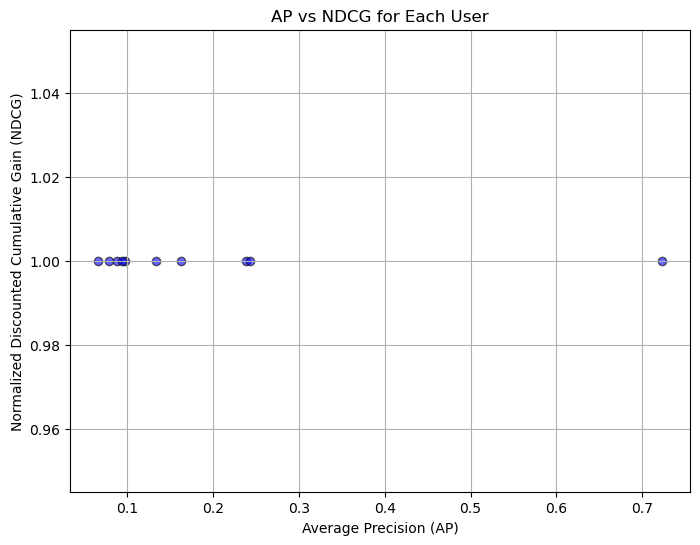

Average AP across users: 0.1923
Average NDCG across users: 1.0000


In [52]:
import matplotlib.pyplot as plt

#Scatter plot of AP vs NDCG
plt.figure(figsize=(8, 6))
plt.scatter(ap_scores, ndcg_scores, color='blue', alpha=0.6, edgecolor='k')
plt.title("AP vs NDCG for Each User")
plt.xlabel("Average Precision (AP)")
plt.ylabel("Normalized Discounted Cumulative Gain (NDCG)")
plt.grid(True)
plt.show()

#Print average AP and NDCG values for reference
print(f"Average AP across users: {average_ap:.4f}")
print(f"Average NDCG across users: {average_ndcg:.4f}")
